ResNet18, 34, 50, VIP, MVP, DINO

In [1]:
from pathlib import Path

from tqdm import trange
from sklearn.manifold import TSNE
import zarr

import torch
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from r3m import load_r3m
import mvp
from vip import load_vip

# Check if CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Device:", device)

Device: cuda


In [2]:
from src.models.encoders import models

**All Files Loading Info**


In [3]:
# NOTE: Change this to wherever the project is located in your google drive
project_root = Path("/home/ubuntu/semrep")
# project_root = Path("/content/drive/MyDrive/17 – Research/sim-2-real-representation-learning") # Lars
data_path = project_root / "data" / "processed"
models_path = project_root / "models"

In [4]:
# Load the data
sim1 = zarr.open(data_path / "one_leg_low_sim.zarr", mode="r")
sim2 = zarr.open(data_path / "one_leg_med_sim.zarr", mode="r")
real = zarr.open(data_path / "one_leg_low_real.zarr", mode="r")
sim1_imgs = sim1["color_image2"]
sim2_imgs = sim2["color_image2"]
real_imgs = real["color_image2"]
sim1_labels = sim1["action/pos"]
sim2_labels = sim2["action/pos"]
real_labels = real["action/pos"]


print(f"Loaded {len(sim1['episode_ends'])} trajectories containing {sim1_imgs.shape[0]} frames")
print(f"Loaded {len(sim2['episode_ends'])} trajectories containing {sim2_imgs.shape[0]} frames")
print(f"Loaded {len(real['episode_ends'])} trajectories containing {real_imgs.shape[0]} frames")

Loaded 50 trajectories containing 23371 frames
Loaded 25 trajectories containing 12263 frames
Loaded 50 trajectories containing 27699 frames


In [5]:
sim1.tree()

Tree(nodes=(Node(disabled=True, name='/', nodes=(Node(disabled=True, name='action', nodes=(Node(disabled=True,…

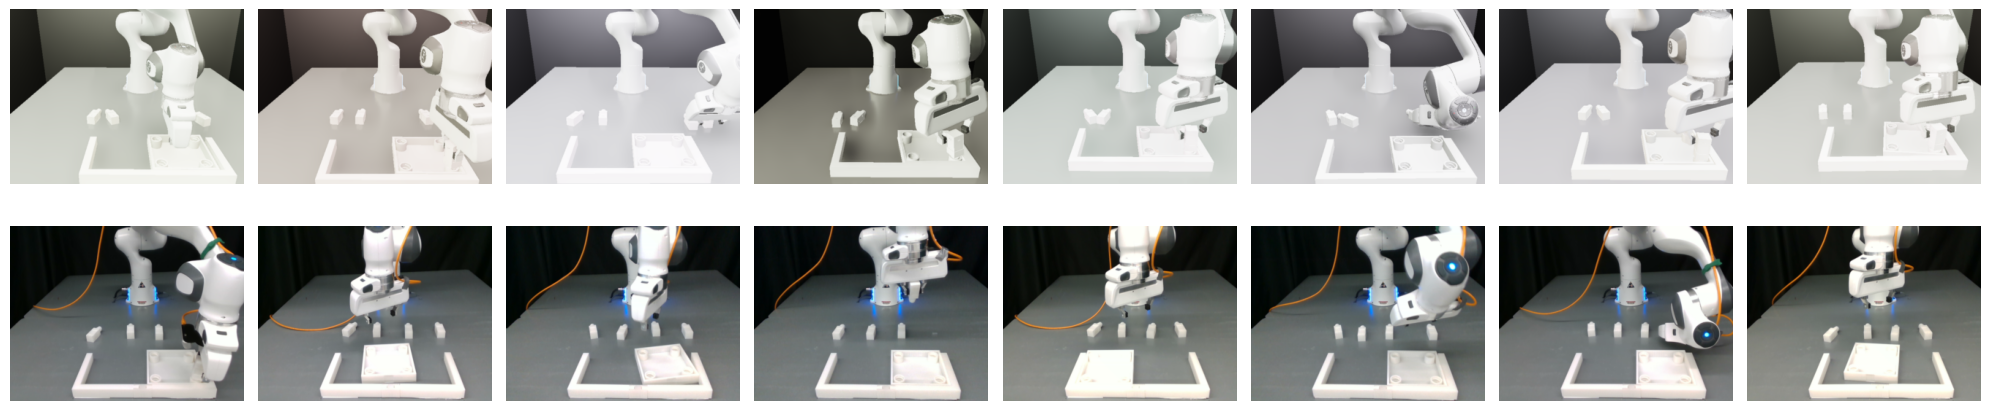

In [6]:
# Sample 8 images from each dataset
sim1_indices = np.random.choice(sim1_imgs.shape[0], size=8, replace=False)
sim2_indices = np.random.choice(sim2_imgs.shape[0], size=8, replace=False)
real_indices = np.random.choice(real_imgs.shape[0], size=8, replace=False)

# Create a figure and axes
fig, axes = plt.subplots(2, 8, figsize=(20, 5))

# # Display the sampled images
# for i, idx in enumerate(sim1_indices):
#     axes[0, i].imshow(sim1_imgs[idx])
#     axes[0, i].axis("off")

for i, idx in enumerate(sim2_indices):
    axes[1 - 1, i].imshow(sim2_imgs[idx])
    axes[1 - 1, i].axis("off")

for i, idx in enumerate(real_indices):
    axes[2 - 1, i].imshow(real_imgs[idx])
    axes[2 - 1, i].axis("off")

plt.tight_layout()
plt.show()

**Load Models**

In [5]:
# Choose the model to use
selected_model_name = "ResNet18"  # Change this to the desired model's name

# Load the selected model
model = models[selected_model_name]().cuda()

model.eval()

/home/ubuntu/miniforge3/envs/sr/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
/home/ubuntu/miniforge3/envs/sr/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/miniforge3/envs/sr/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/ubuntu/miniforge3/envs/sr/lib/python3.10/site-packages/r3m/__init__.py:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly

DataParallel(
  (module): R3M(
    (cs): CosineSimilarity()
    (bce): BCELoss()
    (sigm): Sigmoid()
    (convnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3

### Example of loading our own custom weights

I've trained some models on the data that we've visualized above (the real and the nicely rendered sets). Here, I'll show an example of how we can load up our own weights, and I'd be really curious to see how these embeddings might be different to the pre-trained encoders.

In [6]:
model_names = [
    "confusion_chkpt_999.pt",
    "naive_chkpt_999.pt",
    "upwt_chkpt_999.pt",
]
# Initialize the model to load the weights into
r3m = load_r3m("resnet18").cuda().eval().module

# Read in the state dict from file
wt_path = models_path / "cotraining" / model_names[0]
state_dict = torch.load(wt_path)

r3m.state_dict().keys()

# Load the weights into the model, and we're ready to use it to predict embeddings
r3m.load_state_dict(state_dict)

/tmp/ipykernel_90939/565533732.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(wt_path)


<All keys matched successfully>

**Output Dimensions**

In [7]:
def output():
    if selected_model_name == "MVP" or selected_model_name == "VIP":
        random_input = torch.rand((1, 3, 224, 224)).to(device)  # Move to the correct device
    else:
        random_input = (
            torch.randint(0, 255, size=(1, 3, 224, 224)).float().to(device) / 255.0
        )  # Convert to float and move to device

    # Pass the random data through the encoder
    with torch.no_grad():
        output = model(random_input)

    return output


model_output_dim = output()

**TSNE**

100%|██████████| 5/5 [00:45<00:00,  9.11s/it]


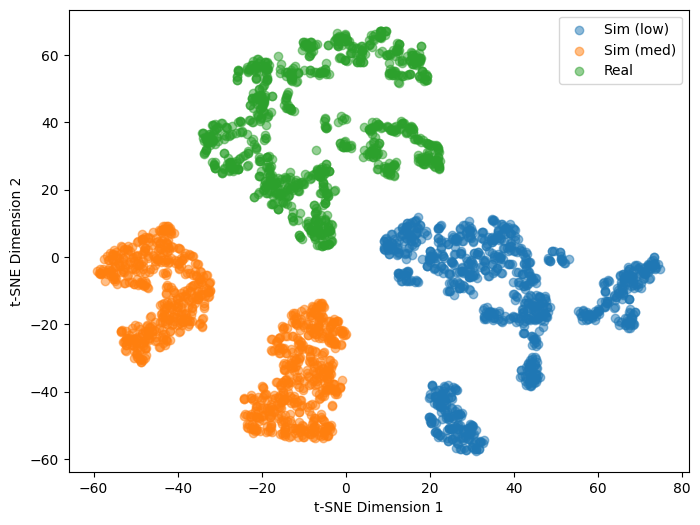

In [12]:
from src.models.tsne import generate_embeddings, plot_tsne

# Generate embeddings
sim1_embeddings, sim2_embeddings, real_embeddings = generate_embeddings(
    model,
    sim1_imgs,
    sim2_imgs,
    real_imgs,
    model_output_dim,
    num_samples=1000,
    batch_size=200,
    selected_model_name="ResNet18",
)

# Plot t-SNE
plot_tsne(sim1_embeddings, sim2_embeddings, real_embeddings, num_samples=1000)

In [1]:
print(model)  # or print(model.module) if using DataParallel
print("hello world")

NameError: name 'model' is not defined

**IMAGE FINDER AND Grad-CAM**

Nearest indices: [ 25 307 756 677 284]
Labels of nearest points: [0. 0. 0. 0. 0.]
Furthest indices: [1253 1991 1410 1333 1499]
Labels of furthest points: [1. 1. 1. 1. 1.]


TypeError: 'Tensor' object is not callable

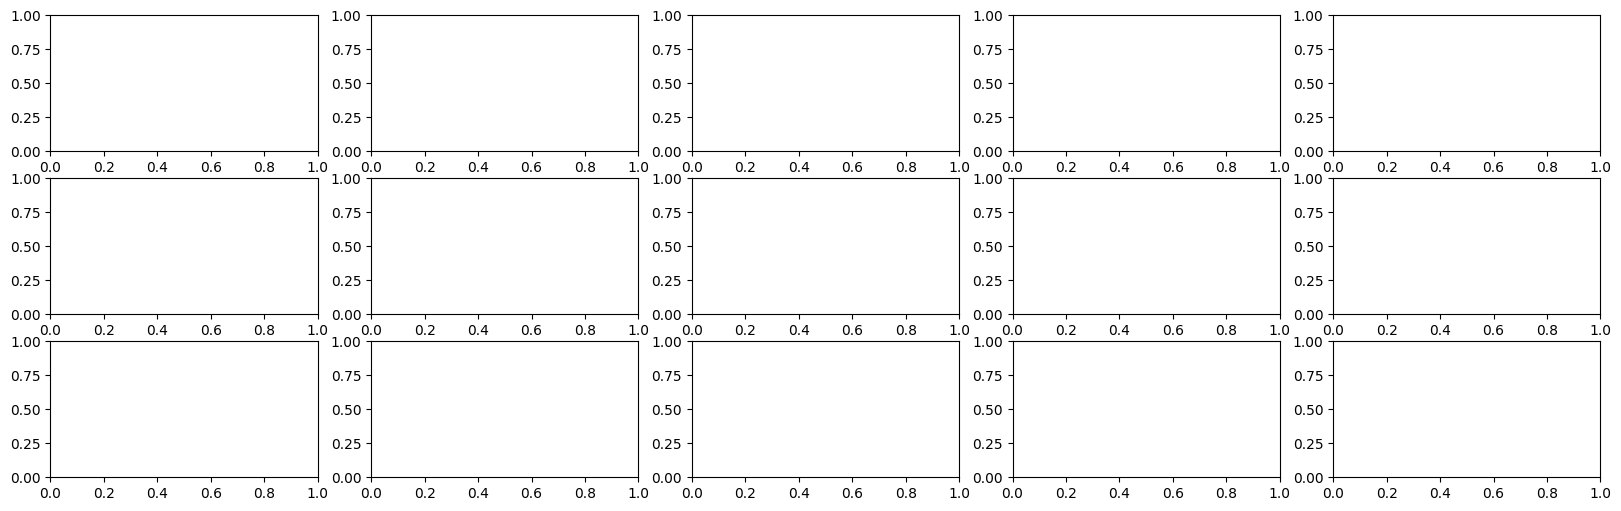

In [ ]:
from PIL import Image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# Load your pre-trained ResNet18 model
model.eval()

# Define the target layer for ResNet18 (usually the last convolutional layer)
target_layers = [model.layer4[-1]]


# Preprocessing function for the image
def preprocess_image(image):
    transform = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )
    return transform(image).unsqueeze(0)  # Add batch dimension


# Load and preprocess the selected image (replace with your image loading method)
selected_idx = 25
selected_point = embeddings_2d[selected_idx]

input_tensor = preprocess_image(selected_point)

# Initialize GradCAM
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=torch.cuda.is_available())

# Specify the target class for CAM visualization; using the top predicted class
with torch.no_grad():
    outputs = model(input_tensor)
    _, predicted_class = outputs.max(dim=1)

# Generate Grad-CAM
targets = [ClassifierOutputTarget(predicted_class.item())]
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# Convert the Grad-CAM result to a visualization
grayscale_cam = grayscale_cam[0, :]  # Extract the first (and only) image's CAM
visualization = show_cam_on_image(np.array(selected_point) / 255.0, grayscale_cam, use_rgb=True)

# Plot the original and Grad-CAM images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(selected_point)
plt.title("Selected Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(visualization)
plt.title("Grad-CAM Visualization")
plt.axis("off")

plt.show()

**SAVE AND LOAD PREVIOUS MODEL**

In [10]:
from pathlib import Path  # Ensure you have imported Path from pathlib


embeddings_path = "/home/ubuntu/semrep/data/embeddings"


embeddings_path = Path(project_root / "embeddings")
embeddings_path.mkdir(parents=True, exist_ok=True)

In [11]:
# Save the embeddings and labels
np.save(embeddings_path / "sim1_embeddings.npy", sim1_embeddings.numpy())
np.save(embeddings_path / "sim2_embeddings.npy", sim2_embeddings.numpy())
np.save(embeddings_path / "real_embeddings.npy", real_embeddings.numpy())
np.save(embeddings_path / "labels.npy", labels)

NameError: name 'sim1_embeddings' is not defined

In [9]:
# Load the embeddings and labels
sim1_embeddings = torch.tensor(np.load(embeddings_path / "sim1_embeddings.npy"))
sim2_embeddings = torch.tensor(np.load(embeddings_path / "sim2_embeddings.npy"))
real_embeddings = torch.tensor(np.load(embeddings_path / "real_embeddings.npy"))
labels = np.load(embeddings_path / "labels.npy")

NameError: name 'embeddings_path' is not defined

**Linear Probing**

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np

# Embeddings and labels (sim1, sim2, real) provided
embeddings = torch.cat([sim1_embeddings, sim2_embeddings, real_embeddings], dim=0)


domain_labels = np.concatenate(
    [np.zeros(len(sim1_embeddings)), np.zeros(len(sim2_embeddings)), np.ones(len(real_embeddings))]
)

domain_labels = torch.tensor(domain_labels, dtype=torch.float32)

domain_dataset = TensorDataset(embeddings, domain_labels)


train_size = int(0.8 * len(domain_dataset))
val_size = len(domain_dataset) - train_size
train_dataset, val_dataset = random_split(domain_dataset, [train_size, val_size])

batch_size = 200
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


class LinearProbe(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearProbe, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set input dimension from embeddings
input_dim = embeddings.shape[1]

domain_probe = LinearProbe(input_dim, 1).to(device)
domain_criterion = nn.BCEWithLogitsLoss()  # Binary classification loss
domain_optimizer = optim.Adam(domain_probe.parameters(), lr=0.001)


def train_probe(probe, criterion, optimizer, train_loader, val_loader, epochs):
    for epoch in range(epochs):
        # Training Phase
        probe.train()
        train_loss = 0.0
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = probe(features)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        probe.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for features, labels in val_loader:
                features, labels = features.to(device), labels.to(device)
                outputs = probe(features)
                loss = criterion(outputs.squeeze(), labels)
                val_loss += loss.item()

                predicted = torch.round(torch.sigmoid(outputs)).squeeze()  # Binary prediction
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_accuracy = correct / total
        print(
            f"Epoch [{epoch+1}/{epochs}] | "
            f"Train Loss: {train_loss/len(train_loader):.4f} | "
            f"Val Loss: {val_loss/len(val_loader):.4f} | "
            f"Val Accuracy: {val_accuracy * 100:.2f}% "
        )


train_probe(domain_probe, domain_criterion, domain_optimizer, train_loader, val_loader, epochs=30)
# split train and val on the trajectory level

Epoch [1/30] | Train Loss: 0.0000 | Val Loss: 0.6782 | Val Accuracy: 62.50% 
Epoch [2/30] | Train Loss: 0.0000 | Val Loss: 0.6782 | Val Accuracy: 62.50% 
Epoch [3/30] | Train Loss: 0.0000 | Val Loss: 0.6782 | Val Accuracy: 62.50% 
Epoch [4/30] | Train Loss: 0.0000 | Val Loss: 0.6782 | Val Accuracy: 62.50% 
Epoch [5/30] | Train Loss: 0.0000 | Val Loss: 0.6782 | Val Accuracy: 62.50% 
Epoch [6/30] | Train Loss: 0.0000 | Val Loss: 0.6782 | Val Accuracy: 62.50% 
Epoch [7/30] | Train Loss: 0.0000 | Val Loss: 0.6782 | Val Accuracy: 62.50% 
Epoch [8/30] | Train Loss: 0.0000 | Val Loss: 0.6782 | Val Accuracy: 62.50% 
Epoch [9/30] | Train Loss: 0.0000 | Val Loss: 0.6782 | Val Accuracy: 62.50% 
Epoch [10/30] | Train Loss: 0.0000 | Val Loss: 0.6782 | Val Accuracy: 62.50% 
Epoch [11/30] | Train Loss: 0.0000 | Val Loss: 0.6782 | Val Accuracy: 62.50% 
Epoch [12/30] | Train Loss: 0.0000 | Val Loss: 0.6782 | Val Accuracy: 62.50% 
Epoch [13/30] | Train Loss: 0.0000 | Val Loss: 0.6782 | Val Accuracy: 62.